<a href="https://colab.research.google.com/github/sorinteodor97/Blood-vessel-segmentation/blob/main/coduldeladiseratie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Incarcarea librariilor folosite
import os
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Model
from keras.losses import binary_crossentropy, mean_squared_error
from keras import optimizers 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Flatten
from keras import initializers
from keras.layers.merge import Concatenate
from keras import backend as K
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping

tf.test.gpu_device_name() 

'/device:GPU:0'

In [5]:
os.chdir("drive/My Drive/Colab Notebooks/vesselseg")

FileNotFoundError: ignored

In [ ]:
# Definirea metodelor de preprocesare


In [6]:
# Definirea funcitiei LOSS
def dice_coeff(y_true, y_pred,smooth = 1):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
    
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [14]:
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
    
def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon()) / (union + K.epsilon()))


In [21]:
# Hyperparameters

loss_list = [binary_crossentropy, bce_dice_loss, tversky_loss, jaccard_distance_loss]
activ_func_list = ['relu', 'LeakyReLU(alpha=0.2)']

In [22]:
# Definirea modelului U-net

def Unet(img_size, n_filters, name='Unet',loss = loss_list[1] , activ_func = activ_func_list[1] , metrics=[mean_iou,'acc']):
        
    # parametri specifici
    k=3 # kernel
    s=2 # stride
    img_ch=3 # input channels
    out_ch=1 # output channel
    padding='same'
    
    inputs = Input((img_size, img_size, img_ch))
    
    conv1 = Conv2D(n_filters, (k, k), padding=padding)(inputs)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = Activation(activ_func)(conv1)    
    conv1 = Conv2D(n_filters, (k, k),  padding=padding)(conv1)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = Activation(activ_func)(conv1)    
    pool1 = MaxPooling2D(pool_size=(s, s))(conv1)
    
    conv2 = Conv2D(2*n_filters, (k, k),  padding=padding)(pool1)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = Activation(activ_func)(conv2)    
    conv2 = Conv2D(2*n_filters, (k, k),  padding=padding)(conv2)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = Activation(activ_func)(conv2)    
    pool2 = MaxPooling2D(pool_size=(s, s))(conv2)
     
    conv3 = Conv2D(4*n_filters, (k, k),  padding=padding)(pool2)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = Activation(activ_func)(conv3)    
    conv3 = Conv2D(4*n_filters, (k, k),  padding=padding)(conv3)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = Activation(activ_func)(conv3)    
    pool3 = MaxPooling2D(pool_size=(s, s))(conv3)
    
    conv4 = Conv2D(8*n_filters, (k, k),  padding=padding)(pool3)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = Activation(activ_func)(conv4)    
    conv4 = Conv2D(8*n_filters, (k, k),  padding=padding)(conv4)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = Activation(activ_func)(conv4)    
    pool4 = MaxPooling2D(pool_size=(s, s))(conv4)
    
    conv5 = Conv2D(16*n_filters, (k, k),  padding=padding)(pool4)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = Activation(activ_func)(conv5)    
    conv5 = Conv2D(16*n_filters, (k, k),  padding=padding)(conv5)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = Activation(activ_func)(conv5)
    
    up1 = Concatenate(axis=3)([UpSampling2D(size=(s, s))(conv5), conv4])
    conv6 = Conv2D(8*n_filters, (k, k),  padding=padding)(up1)
    conv6 = BatchNormalization(scale=False, axis=3)(conv6)
    conv6 = Activation(activ_func)(conv6)    
    conv6 = Conv2D(8*n_filters, (k, k),  padding=padding)(conv6)
    conv6 = BatchNormalization(scale=False, axis=3)(conv6)
    conv6 = Activation(activ_func)(conv6)    
     
    up2 = Concatenate(axis=3)([UpSampling2D(size=(s, s))(conv6), conv3])
    conv7 = Conv2D(4*n_filters, (k, k),  padding=padding)(up2)
    conv7 = BatchNormalization(scale=False, axis=3)(conv7)
    conv7 = Activation(activ_func)(conv7)    
    conv7 = Conv2D(4*n_filters, (k, k),  padding=padding)(conv7)
    conv7 = BatchNormalization(scale=False, axis=3)(conv7)
    conv7 = Activation(activ_func)(conv7)    
    
    up3 = Concatenate(axis=3)([UpSampling2D(size=(s, s))(conv7), conv2])
    conv8 = Conv2D(2*n_filters, (k, k),  padding=padding)(up3)
    conv8 = BatchNormalization(scale=False, axis=3)(conv8)
    conv8 = Activation(activ_func)(conv8)    
    conv8 = Conv2D(2*n_filters, (k, k),  padding=padding)(conv8)
    conv8 = BatchNormalization(scale=False, axis=3)(conv8)
    conv8 = Activation(activ_func)(conv8)
    
    up4 = Concatenate(axis=3)([UpSampling2D(size=(s, s))(conv8), conv1])
    conv9 = Conv2D(n_filters, (k, k),  padding=padding)(up4)
    conv9 = BatchNormalization(scale=False, axis=3)(conv9)
    conv9 = Activation(activ_func)(conv9)    
    conv9 = Conv2D(n_filters, (k, k),  padding=padding)(conv9)
    conv9 = BatchNormalization(scale=False, axis=3)(conv9)
    conv9 = Activation(activ_func)(conv9)
    
    outputs = Conv2D(out_ch, (1, 1), padding=padding, activation='sigmoid')(conv9)
    
    model = Model(inputs, outputs, name=name)
    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

    model = Unet(512,64)

In [23]:
# Vizualizarea structurii modelului 

model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 512, 512, 64) 192         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 512, 512, 64) 0           batch_normalization_36[0][0]     
_______________________________________________________________________________________________

In [12]:
data_gen_args = dict(rescale=1./255,
                     rotation_range=90,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 8
image_generator =image_datagen.flow_from_directory("dataset_allsize/training/images",
                                                    target_size=(512,512),
                                                    class_mode=None,
                                                    batch_size=4,
                                                    seed=seed)

mask_generator = mask_datagen.flow_from_directory("dataset_allsize/training/mask",
                                                  target_size=(512,512),
                                                  color_mode='grayscale',
                                                  class_mode=None,
                                                  batch_size=4, 
                                                  seed=seed)

train_generator = zip(image_generator, mask_generator)

# Validation generator

validation_datagen_img = ImageDataGenerator(rescale=1./255)
validation_datagen_mask = ImageDataGenerator(rescale=1./255)

image_generator_validation =validation_datagen_img.flow_from_directory("dataset_allsize/testing/images", target_size=(512,512),
                                                    class_mode=None,shuffle=False,batch_size=4, seed=seed)

mask_generator_validation = validation_datagen_mask.flow_from_directory("dataset_allsize/testing/mask",color_mode="grayscale", target_size=(512,512),
                                                   class_mode=None,shuffle=False,batch_size=4, seed=seed)
validation_generator = zip(image_generator_validation, mask_generator_validation)

Found 75 images belonging to 1 classes.
Found 75 images belonging to 1 classes.
Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.


In [24]:
# Training parameters
earlystopper = EarlyStopping(
            patience=10,
            verbose=1)

model_checkpoint = ModelCheckpoint(
            "model512v2.h5",
            save_weights_only=False,
            monitor='loss',
            verbose=1,
            save_best_only=True)

# Training
history= model.fit(
    train_generator,
    steps_per_epoch=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=30,
    callbacks=[model_checkpoint, earlystopper])

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.3491 - mean_iou: 0.6429 - acc: 0.9212
Epoch 00001: loss improved from inf to 0.34913, saving model to modele512/model512v2.h5
50/50 [==============================] - 55s 1s/step - loss: 0.3491 - mean_iou: 0.6429 - acc: 0.9212 - val_loss: 0.3393 - val_mean_iou: 0.6446 - val_acc: 0.9674
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.3447 - mean_iou: 0.6465 - acc: 0.9215
Epoch 00002: loss improved from 0.34913 to 0.34467, saving model to modele512/model512v2.h5
50/50 [==============================] - 57s 1s/step - loss: 0.3447 - mean_iou: 0.6465 - acc: 0.9215 - val_loss: 0.3214 - val_mean_iou: 0.6614 - val_acc: 0.9703
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.3421 - mean_iou: 0.6477 - acc: 0.9225
Epoch 00003: loss improved from 0.34467 to 0.34212, saving model to modele512/model512v2.h5
50/50 [==============================] - 59s 1s/step - loss: 0.3421 - mean_iou: 0.

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training and validation loss')

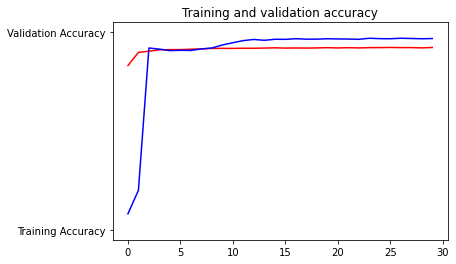

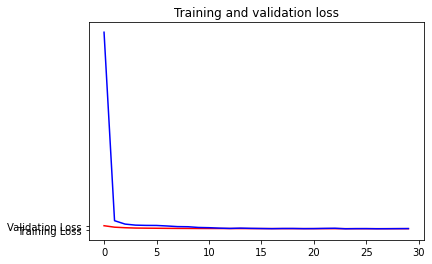

In [18]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
from keras.models import load_model
model = load_model('versiuni.h5',custom_objects={'bce_dice_loss': bce_dice_loss})

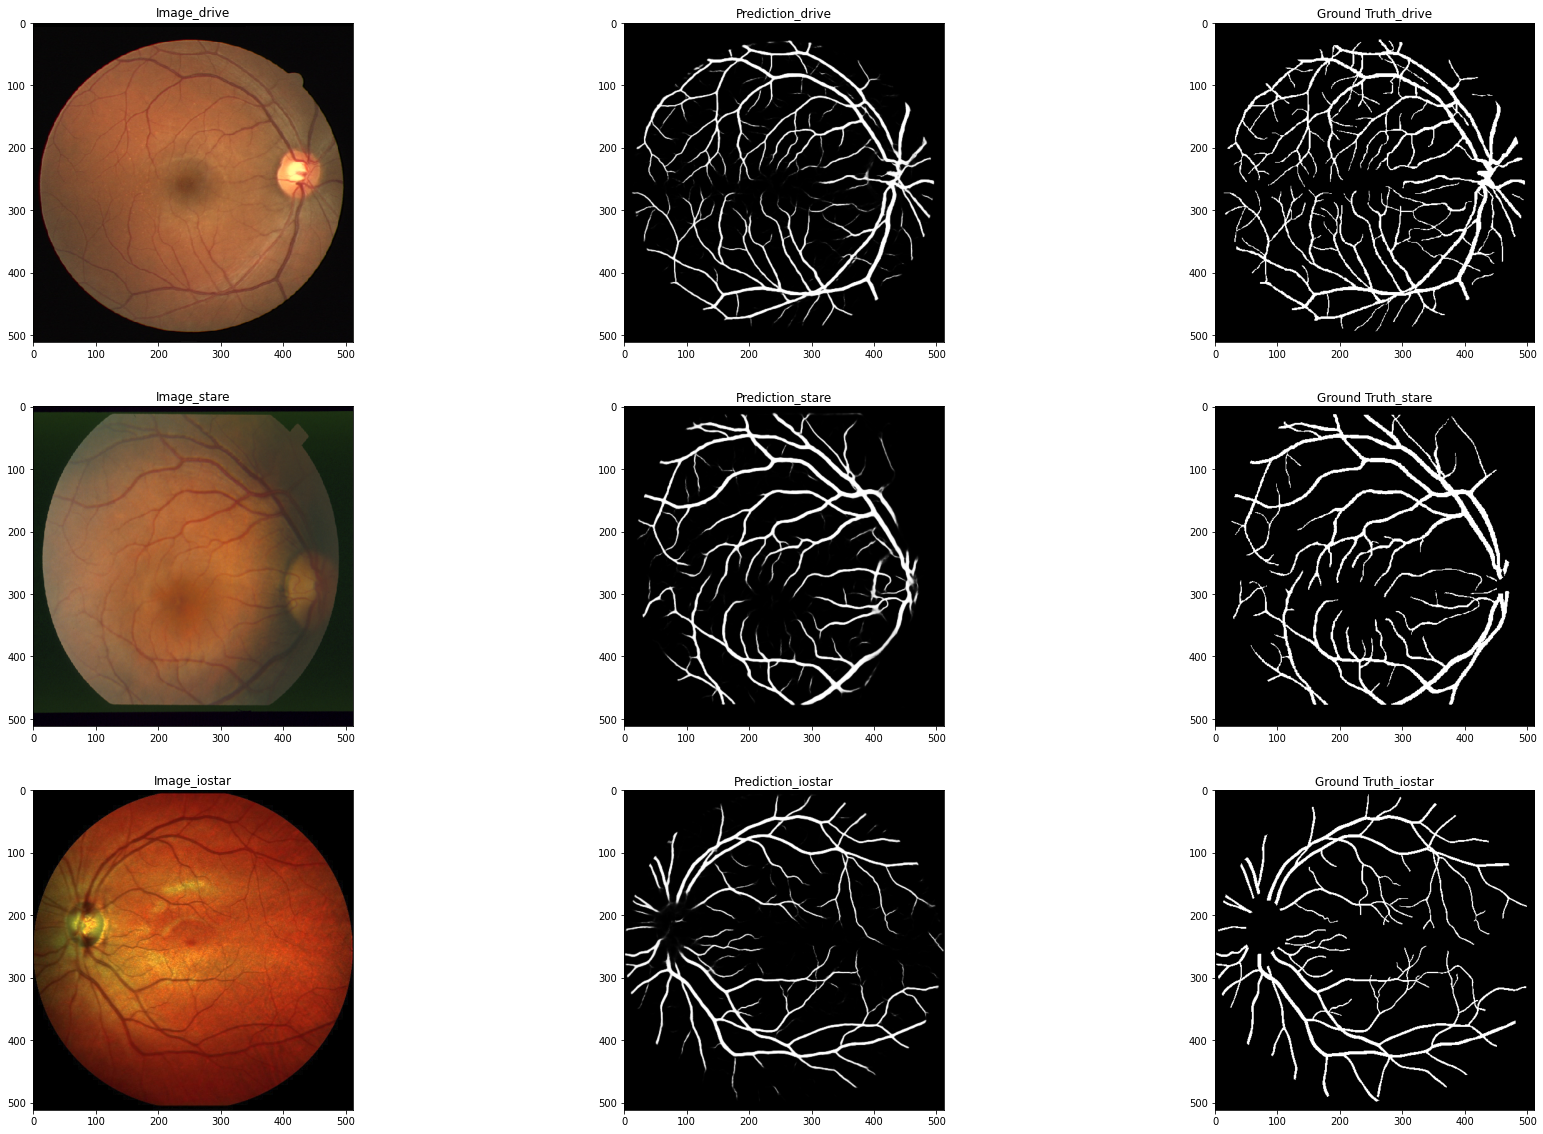

In [19]:
# Generate predictions for all images in the validation set

# Predict on image

# Drive
image_drive = tf.keras.preprocessing.image.load_img("dataset_allsize/testing/images/images/36_training.tif",target_size=(512,512))
input_arr_drive = keras.preprocessing.image.img_to_array(image_drive)/255
input_arr_drive = input_arr_drive.reshape(-1, 512, 512, 3)
predictions_drive = model.predict(input_arr_drive)
predictions_drive = predictions_drive.reshape(512,512)
mask_drive = tf.keras.preprocessing.image.load_img("dataset_allsize/testing/mask/mask/36_manual1.png",target_size=(512,512))

# Stare
image_stare = tf.keras.preprocessing.image.load_img("dataset_allsize/testing/images/images/im0240.ppm",target_size=(512,512))
input_arr_stare = keras.preprocessing.image.img_to_array(image_stare)/255
input_arr_stare = input_arr_stare.reshape(-1, 512, 512, 3)
predictions_stare = model.predict(input_arr_stare)
predictions_stare = predictions_stare.reshape(512,512)
mask_stare = tf.keras.preprocessing.image.load_img("dataset_allsize/testing/mask/mask/im0240.ah.ppm",target_size=(512,512))

# Iostar
image_iostar = tf.keras.preprocessing.image.load_img("dataset_allsize/testing/images/images/STAR 40_OSC.jpg",target_size=(512,512))
input_arr_iostar = keras.preprocessing.image.img_to_array(image_iostar)/255
input_arr_iostar = input_arr_iostar.reshape(-1, 512,512, 3) 
predictions_iostar = model.predict(input_arr_iostar)
predictions_iostar = predictions_iostar.reshape(512,512)
mask_iostar = tf.keras.preprocessing.image.load_img("dataset_allsize/testing/mask/mask/STAR 40_OSC_GT.tif",target_size=(512,512))

# Plot the images
f, axarr = plt.subplots(3,3,figsize=(30, 20))
axarr[0,0].set_title('Image_drive')
axarr[0,1].set_title('Prediction_drive')
axarr[0,2].set_title('Ground Truth_drive')
axarr[0,0].imshow(image_drive)
axarr[0,1].imshow(predictions_drive,cmap="gray")
axarr[0,2].imshow(mask_drive)

axarr[1,0].set_title('Image_stare')
axarr[1,1].set_title('Prediction_stare')
axarr[1,2].set_title('Ground Truth_stare')
axarr[1,0].imshow(image_stare)
axarr[1,1].imshow(predictions_stare,cmap="gray")
axarr[1,2].imshow(mask_stare)

axarr[2,0].set_title('Image_iostar')
axarr[2,1].set_title('Prediction_iostar')
axarr[2,2].set_title('Ground Truth_iostar')
axarr[2,0].imshow(image_iostar)
axarr[2,1].imshow(predictions_iostar,cmap="gray")
axarr[2,2].imshow(mask_iostar)